In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr, spearmanr
from transformers import AutoTokenizer, EsmModel
import time
import lightning as L
import os
import scipy
import scipy.stats
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [3]:
class ProtEmbeddingDiffDataset(Dataset):
    def __init__(self, tensor_folder, csv_file):
        self.df = pd.read_csv(csv_file)
        
        # build wt lookup: WT_name → wt embedding filename
        wt_df = self.df[self.df.mut_type == 'wt']
        wt_lookup = dict(zip(wt_df['WT_name'], wt_df['name']))
        
        # only keep mutation rows
        self.df = self.df[self.df.mut_type != 'wt'].reset_index(drop=True)
        self.labels   = torch.tensor(self.df['ddG_ML'].values)

        # preload all embeddings into RAM
        print("Loading embeddings into RAM...")
        self.embeddings = []
        for idx, row in self.df.iterrows():
            # mutant embedding
            mut_emb = torch.load(os.path.join(tensor_folder, row['name'] + '.pt'))['mean_representations'][6]
            # wildtype embedding
            wt_emb  = torch.load(os.path.join(tensor_folder, wt_lookup[row['WT_name']] + '.pt'))['mean_representations'][6]
            # difference
            diff = mut_emb - wt_emb
            # concatenate → (2304,)
            self.embeddings.append(torch.cat([mut_emb, wt_emb, diff], dim=0))
            #self.embeddings.append(torch.cat([diff], dim=0))
            #self.embeddings.append(torch.cat([mut_emb, wt_emb], dim=0))


        print("Done!")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx].float()

In [4]:
dataset_train = ProtEmbeddingDiffDataset(
    'data/mega_train_embeddings',
    'data/mega_train.csv'
)
dataset_val = ProtEmbeddingDiffDataset(
    'data/mega_val_embeddings',
    'data/mega_val.csv'
)

loader_train = DataLoader(dataset_train, batch_size=2048, shuffle=True,  num_workers=4)
loader_val   = DataLoader(dataset_val,   batch_size=1024,  shuffle=False, num_workers=4)

Loading embeddings into RAM...
Done!
Loading embeddings into RAM...
Done!


In [11]:

from torchmetrics.regression import PearsonCorrCoef, SpearmanCorrCoef

class StabModel(L.LightningModule):
    def __init__(self, input_dim=2304, lr=1e-2, dropout_prob = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 64),
            #nn.BatchNorm1d(64),

            nn.ReLU(),
            nn.Dropout(dropout_prob),
            #nn.BatchNorm1d(64),
            nn.Linear(64, 1)

        )
        self.loss_fn = nn.MSELoss()
        self.lr = lr

        # Metrics
        self.val_pearson = PearsonCorrCoef()
        self.val_spearman = SpearmanCorrCoef()

    def forward(self, x):
        return self.model(x).squeeze(1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        
        # Print Train Loss to console/progress bar
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        
        # Update correlation metrics
        self.val_pearson(preds, y)
        self.val_spearman(preds, y)
        # Print Val stats to console/progress bar
        self.log("val_loss", loss,  on_epoch=True, prog_bar=True)
        self.log("val_pear", self.val_pearson, on_epoch=True, prog_bar=True)
        self.log("val_spear", self.val_spearman, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.lr)

'''
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            # monitor ='val_loss',
            patience=2,       # wait 2 epochs before reducing
            factor=0.8        # halve the lr each time
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }
        '''


"\n    def configure_optimizers(self):\n        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)\n        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(\n            optimizer,\n            # monitor ='val_loss',\n            patience=2,       # wait 2 epochs before reducing\n            factor=0.8        # halve the lr each time\n        )\n        return {\n            'optimizer': optimizer,\n            'lr_scheduler': {\n                'scheduler': scheduler,\n                'monitor': 'val_loss'\n            }\n        }\n        "

/home/course/bc_NN/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode  | FLOPs
------------------------------------------------------------------
0 | model        | Sequential       |

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/course/bc_NN/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


RMSE: 0.5697808265686035
Pearson r: PearsonRResult(statistic=0.5790981, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.5424386167802613, pvalue=0.0)


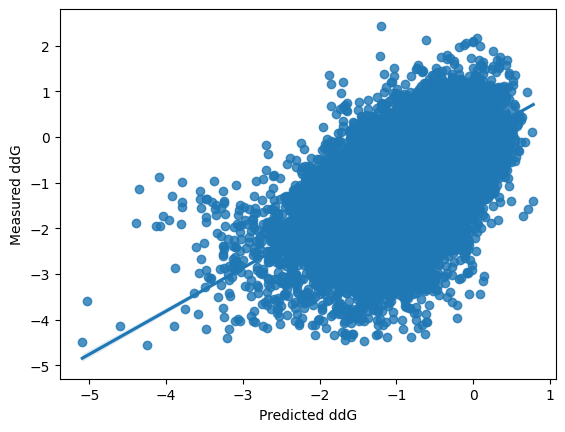

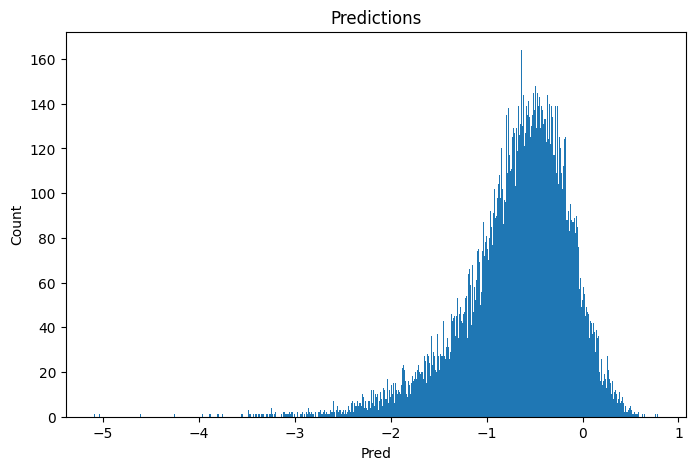

In [12]:
model = StabModel(lr = 1e-5)

trainer = L.Trainer(devices =1, max_epochs= 15)
trainer.fit(model, loader_train, loader_val)

preds =[]
all_y = []
# save all predictions
for batch in loader_val:
    # adjust this to work with your model
    x,y = batch
    y_hat = model(x)
    preds.append(y_hat.squeeze().detach().numpy())
    all_y.append(y.detach().numpy())

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

#Plot predictions
plt.figure(figsize=(8,5))
plt.hist(preds,bins=1000)
plt.xlabel("Pred")
plt.ylabel("Count")
plt.title("Predictions")
plt.show()

In [114]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs


Reusing TensorBoard on port 6010 (pid 221768), started 20:27:17 ago. (Use '!kill 221768' to kill it.)